# Numerical summaries and standardization of multivariate data

Doing the folowing calculations:
* mean vector and (sample) standard deviation (using pandas describe)
* standardizing data (using numpy / pandas)
* covariance matrix (using np.cov / pandas)
* correlation matrix (using pd.corr)

In [1]:
df = pd.read_csv('./data/housing.csv', header=0)
df.head(3)

,region,authority,houseprice,income
0,East Midlands,Amber Valley,84828.000,28509.000
1,East Midlands,Bolsover,72854.000,23322.000
2,East Midlands,Chesterfield,92295.000,28409.000


## Calculate mean and sample standard deviation
The standard deviation calculated by describe is the sample standard deviation, so degrees of freedom = 1.

In [2]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
houseprice,353.000,121054.011,61563.273,50195.000,80676.000,110574.000,145507.000,617433.000
income,353.000,33426.703,8990.826,18387.000,27608.000,31483.000,37318.000,98553.000


### Calculate mean per group

In [3]:
mean_per_group = (df
    .groupby('region')
    .agg({'region': np.size, 'income': np.mean, 'houseprice': np.mean, })
    .sort_values(by='income')
)
mean_per_group

,region,income,houseprice
region,,,
North East,23,27518.652,61835.696
North West,43,28380.581,69140.651
Yorkshire and Humberside,21,28448.000,70378.762
South West,44,28710.227,126463.932
East Midlands,40,29843.175,90586.375
West Midlands,34,32674.618,97331.118
Eastern,48,33710.042,127184.938
South East,67,38995.373,157372.776
London,33,46976.909,233723.152


#### It's always good to visualize your numbers:  
London and South West jump out: the distance in the graph between income and houseprice is much smaller in those regions.

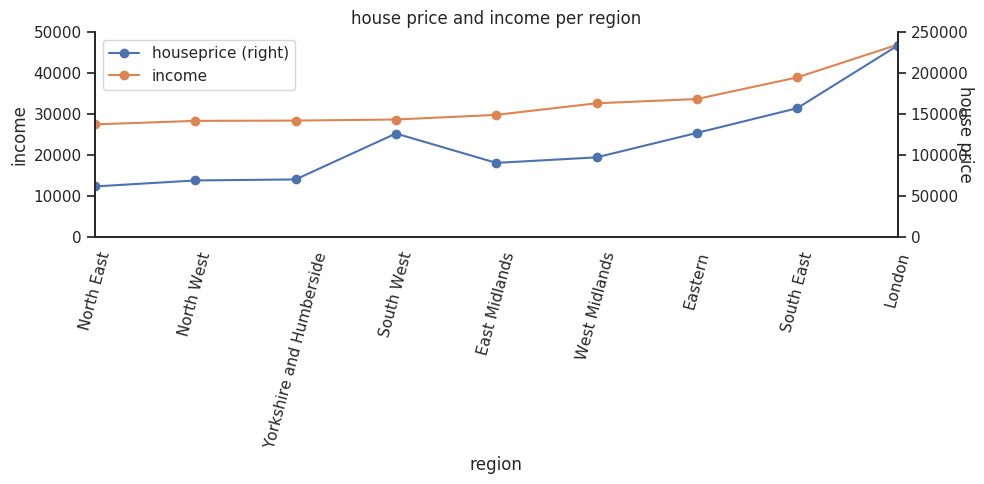

In [4]:
ax = mean_per_group[['houseprice', 'income']].plot(
    secondary_y=['houseprice'], 
    kind='line',
    style='-o',
    figsize=(10,5), 
    rot=75,
)
ax.set(title='house price and income per region', ylabel='income', ylim=(0, 50000))
plt.xticks(ticks=range(len(mean_per_group)), labels=mean_per_group.index)

# add ylabel and ylim for the secondary y-axis houseprice
plt.ylabel('house price', rotation=-90)
plt.ylim((0, 250000))

# make plot nicer
sns.despine(right=False)
plt.tight_layout();

## Standardizing data  

To standardize a variable you apply the following formula to every value:  
$ z_{i1} = \dfrac{x_{i1} - \bar{x_1}}{s_1}$ where $s_1$ is the sampling standard deviation of variable $X_1$

There is difference between using pandas or scikit learn to standardize your data.  
Pandas uses 1 degree of freedom (sample sd), while scikit uses 0 degrees of freedom (population sd).

### Standardizing the pandas way  
This uses 1 degree of freedom to calculate the sample sd.

In [5]:
num_columns = ['houseprice', 'income']
df_zscores = (df[num_columns] - df[num_columns].mean()) / df[num_columns].std(ddof=1)
df = df.join(df_zscores, rsuffix='_z')

In [6]:
df.head(3)

,region,authority,houseprice,income,houseprice_z,income_z
0,East Midlands,Amber Valley,84828.000,28509.000,-0.588,-0.547
1,East Midlands,Bolsover,72854.000,23322.000,-0.783,-1.124
2,East Midlands,Chesterfield,92295.000,28409.000,-0.467,-0.558


### Standardizing the sklearn way

If you use scikit learn to scale / standardize your data, this uses 0 degrees of freedom for the standard deviation (= population sd), so this gives different results.  
Technically this is wrong, but if you're using it for machine learning, it probably won't affect your final machine learning model. 

In [7]:
from sklearn.preprocessing import scale
scale(df[num_columns], with_mean=True, with_std=True)[0:3]

array([[-0.58927069, -0.54774532],
       [-0.78404585, -1.12548563],
       [-0.46780867, -0.55888356]])

### Plotting the standardized values  
There are some clear outliers :)  
Interactivity with plotly is nice, but still quite verbose...

In [8]:
import plotly.graph_objs as go

fig = go.FigureWidget(
    data=[
        {
            'x': df[df.region == region]['income_z'],
            'y': df[df.region == region]['houseprice_z'],
            'name': region,
            'text': df[df.region == region]['authority'],
            'hoverinfo': 'x+y+text+name',
            'mode': 'markers',
            'type': 'scatter',
        } for region in df.region.unique().tolist()
    ], 
    layout={
        'title': 'Relationship standardized income and household',
        'xaxis': {'range': [-2, 9], 'title': 'income_z'},
        'yaxis': {'range': [-2, 9], 'title': 'houseprice_z'},
        'width': 1000,  # size of plot
        'height': 500,  # size of plot
        'hovermode': 'closest',
    }
)
fig

FigureWidget({
    'data': [{'hoverinfo': 'x+y+text+name',
              'mode': 'markers',
              'nam…

## Calculate correlation matrix

#### Reading the data

In [9]:
df_math = pd.read_csv(
    './data/mathsability.csv', 
    header=0, 
    usecols=['age', 'geometry', 'arithmetic', 'algebra'],
)
df_math.head(3)

,age,geometry,arithmetic,algebra
0,16.250,55.000,49.000,41.000
1,15.417,48.000,93.000,79.000
2,14.917,85.000,65.000,62.000


#### Checking the ranges of the data with a boxplot

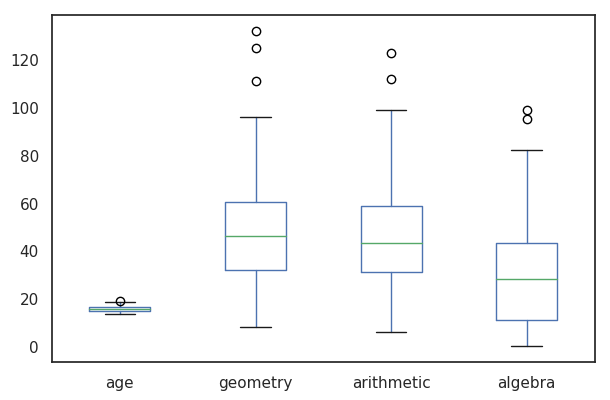

In [10]:
df_math.plot(kind='box');

#### Calculating covariance matrix with numpy cov

In [11]:
numpy_cov_matrix = np.cov(df_math, rowvar=False)
cov_matrix = pd.DataFrame(
    numpy_cov_matrix, 
    columns=df_math.columns, 
    index=df_math.columns
)
cov_matrix

,age,geometry,arithmetic,algebra
age,1.456,3.030,0.049,4.812
geometry,3.030,637.597,330.666,327.306
arithmetic,0.049,330.666,588.932,383.768
algebra,4.812,327.306,383.768,559.712


#### Calculating correlation matrix with pandas
Nice and easy

In [12]:
df_math.corr()

,age,geometry,arithmetic,algebra
age,1.000,0.099,0.002,0.169
geometry,0.099,1.000,0.540,0.548
arithmetic,0.002,0.540,1.000,0.668
algebra,0.169,0.548,0.668,1.000


#### P-values for your correlations  
Unfortunately I have to write my own custom function to get an overview of all p-values

In [13]:
from scipy.stats import pearsonr

In [14]:
columns = df_math.columns
size_needed = columns.size
corr_matrix = np.zeros((size_needed, size_needed))
pvalues_matrix = np.zeros((size_needed, size_needed))

# calculate for every combination of 2 columns the correlation with scipy.stats.pearsonr, 
# so you also right away get the pvalue of the correlation
# this looks bad, because it's not vectorized
for row_nr in range(size_needed):
    for col_nr in range(size_needed):
        if row_nr != col_nr:
            correlation, pvalue = pearsonr(
                df_math.iloc[:, row_nr], 
                df_math.iloc[:, col_nr]
            )
            corr_matrix[row_nr][col_nr] = correlation
            pvalues_matrix[row_nr][col_nr] = pvalue
        elif row_nr == col_nr:
            corr_matrix[row_nr][col_nr] = 0
            pvalues_matrix[row_nr][col_nr] = 0
        
corr_df = pd.DataFrame(np.round(corr_matrix, decimals=3), index=columns, columns=columns)
pvalues_df = pd.DataFrame(np.round(pvalues_matrix, decimals=3), index=columns, columns=columns)

#### Visualizing correlation matrix

I really like the pandas way of visualizing the dataframe.  
It's not a graph, it's just background coloring.  
Nice thing is, with axis=0, axis=1, or axis=None, you can control if the background coloring is determined over row, column or the whole dataframe.  
Check out StackOverflow on this topic: [Stackoverflow correlation matrix][so]  


[so]:https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

In [15]:
corr_df.style.background_gradient(cmap='coolwarm', axis=None)

,age,geometry,arithmetic,algebra
age,0,0.099,0.002,0.169
geometry,0.099,0,0.54,0.548
arithmetic,0.002,0.54,0,0.668
algebra,0.169,0.548,0.668,0


In [16]:
pvalues_df.style.background_gradient(cmap='coolwarm', axis=None)

,age,geometry,arithmetic,algebra
age,0,0.371,0.988,0.128
geometry,0.371,0,0,0
arithmetic,0.988,0,0,0
algebra,0.128,0,0,0
